In [24]:
import urllib
from datetime import datetime

import numpy as np
import pandas as pd

import hvplot.pandas

from neuclease.dvid import *
from neuclease.util import *
from neuclease.focused.ingest import fetch_focused_decisions

from neuclease import configure_default_logging
configure_default_logging()

### Proofreader Decisions

In [4]:
vnc_focused = ('https://hemibrain-dvid2.janelia.org', '36e0b', 'segmentation_focused')
decisions = fetch_focused_decisions(*vnc_focused, normalize_pairs='sv', update_with_instance=None, is_hemibrain=False)

# Use separate score columns depending on which process was used to generate the tasks
decisions['score'] = [info['score'] if 'score' in info else np.nan for info in tqdm_proxy(decisions['edge_info'])]
decisions['synth_score'] = [info['synth_score'] if 'synth_score' in info else np.nan for info in tqdm_proxy(decisions['edge_info'])]

[2020-10-14 10:20:54,251] INFO Fetching keys from 'segmentation_focused'...
[2020-10-14 10:20:55,316] INFO Fetching keys from 'segmentation_focused' took 0:00:01.063417
[2020-10-14 10:20:55,316] INFO Fetching values from 'segmentation_focused'...


[2020-10-14 10:21:10,773] INFO Fetching values from 'segmentation_focused' took 0:00:15.456224


In [98]:
decisions['date_eastern'].astype(str).value_counts().rename('total tasks per day').sort_index(ascending=False).hvplot.barh()

:Bars   [index]   (total tasks per day)

### Check today's merge rate

,count,pct
result,,
dontMerge,1046,58.8
merge,725,40.8
dontKnow,8,0.4
skip (same body ID),0,0.0


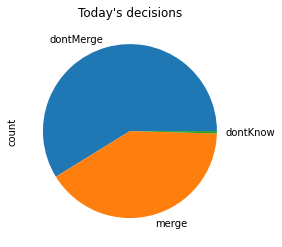

In [35]:
today = datetime.now().date()
today_decisions = decisions.query('date_eastern == @today')

vc = today_decisions['result'].value_counts().rename('count').rename_axis('result').to_frame()
vc['pct'] = 100*(vc['count'] / vc['count'].sum())
vc['pct'] = np.round(vc['pct'], 1)
display(vc)
vc['count'].plot(kind='pie', title="Today's decisions");

### Per-user analysis

In [99]:
df = decisions

# Optional: Query for some decisions only
#df = decisions.query('not synth_score.isnull()')

user_merge_rates = df.groupby('user')['result'].agg(lambda s: s.value_counts()).reset_index()
user_merge_rates.columns = ['user', 'result', 'count']
user_merge_rates = user_merge_rates.merge( user_merge_rates.groupby('user')['count'].sum().rename('total_tasks').reset_index(), 'left', on='user' )
user_merge_rates = user_merge_rates.sort_values('total_tasks')
user_merge_rates['rate'] = user_merge_rates['count'] / user_merge_rates['total_tasks']
user_merge_rates = user_merge_rates.query('count > 0')

In [97]:
user_merge_rates.set_index(['user', 'result'])['count'].hvplot.barh(stacked=True, height=400, legend='bottom_right', title='decisions per user')

:Bars   [user,result]   (count)

In [95]:
user_merge_rates.set_index(['user', 'result'])['rate'].hvplot.barh(stacked=True, height=400, legend='bottom_left', title='decision rates per user')

:Bars   [user,result]   (rate)

### Show a selection of decisions

In [100]:
cols = ['sv_a', 'sv_b', 'body_a', 'body_b', 'xa', 'ya', 'za', 'xb', 'yb', 'zb', 'score', 'synth_score', 'user']

# Example query
q = "date_eastern == @today and result == 'merge'"

selections = decisions.query(q).sort_values('synth_score')
selections[cols].head(10)

,sv_a,sv_b,body_a,body_b,xa,ya,za,xb,yb,zb,score,synth_score,user
208151,25262564872,26079734562,25262564872,26079734562,13028,33508,32864,13038,33468,32878,NaN,5.0,emanley8794@gmail.com
208779,6712652361,9174741806,6712652361,9174741806,25320,21378,11618,25320,21378,11619,NaN,5.0,thomsonrymer@gmail.com
208059,21148334755,26865102168,21148334755,26865102168,13826,28331,33284,13914,28228,33431,NaN,5.0,natalielynnsmith@gmail.com
208073,29678592866,30499219025,29678592866,30499219025,27744,19468,38216,27724,19468,38215,NaN,5.0,alanna.lohff@gmail.com
208087,39264418528,48224970953,39264418528,48224970953,16414,31715,60774,16416,31620,60736,NaN,5.0,alanna.lohff@gmail.com
209008,15734046642,17778504619,15734046642,17778504619,32896,19563,22413,32896,19562,22413,NaN,5.0,anniekayscott@gmail.com
208098,30933551823,30933552322,30933551823,30933552322,17365,23079,38912,17308,23056,38936,NaN,5.0,emanley8794@gmail.com
209010,29709835756,29709836687,29709835756,29709836687,21090,23961,37126,21090,23961,37127,NaN,5.0,natalielynnsmith@gmail.com
207714,42426982404,43696682738,42426982404,43696682738,13074,29807,54336,13056,29700,54394,NaN,5.0,alanna.lohff@gmail.com
208725,25175222375,25585574020,25175222375,25585574020,27308,20960,31760,27350,20832,31891,NaN,5.0,slauchie@gmail.com


### Neuroglancer link for a particular task

In [46]:
DEFAULT_NG_SETTINGS = {
  "dimensions": {
    "x": [
      8e-9,
      "m"
    ],
    "y": [
      8e-9,
      "m"
    ],
    "z": [
      8e-9,
      "m"
    ]
  },
  "position": [
    22491.5,
    26671.6328125,
    31805.267578125
  ],
  "crossSectionScale": 1.1903340818685682,
  "projectionScale": 16050.60896397486,
  "layers": [
    {
      "type": "image",
      "source": {
        "url": "precomputed://gs://flyem-vnc-2-26-213dba213ef26e094c16c860ae7f4be0/v3_emdata_clahe_xy/jpeg",
        "subsources": {
          "default": True,
          "bounds": True
        },
        "enableDefaultSubsources": False
      },
      "tab": "source",
      "name": "v3_emdata_clahe_xy/jpeg"
    },
    {
      "type": "segmentation",
      "source": "precomputed://gs://vnc-v3-seg-3d2f1c08fd4720848061f77362dc6c17/rc4_wsexp",
      "tab": "source",
      "segments": [],
      "name": "supervoxels"
    },
    {
      "type": "segmentation",
      "source": "precomputed://gs://vnc-v3-seg-3d2f1c08fd4720848061f77362dc6c17/rc4_wsexp_rsg32_16_sep_8_sep1e6",
      "tab": "segments",
      "name": "agglo-8nm-except-1M-1M-merges",
      "visible": False
    }
  ],
  "showSlices": False,
  "prefetch": False,
  "selectedLayer": {
    "layer": "supervoxels",
    "visible": True
  },
  "layout": "4panel",
  "partialViewport": [
    0,
    0,
    1,
    1
  ]
}

In [47]:
def ng_link_for_row(tasks, index):
    ng_settings = copy.deepcopy(DEFAULT_NG_SETTINGS)

    sv_settings = [l for l in ng_settings["layers"] if l["name"] == "supervoxels" ][0]
    agglo_settings = [l for l in ng_settings["layers"] if l["name"].startswith("agglo")][0]

    sv_settings["segments"] = tasks.loc[index, ['sv_a', 'sv_b']].values.astype(str).tolist()
    agglo_settings["segments"] = tasks.loc[index, ['body_a', 'body_b']].values.astype(str).tolist()
    
    point_a = tasks.loc[index, ['xa', 'ya', 'za']].values
    point_b = tasks.loc[index, ['xb', 'yb', 'zb']].values
    midpoint = (point_a + point_b) / 2
    ng_settings["position"] = midpoint.tolist()
    
    url = "https://neuroglancer-demo.appspot.com/#!" + urllib.parse.quote(json.dumps(ng_settings))
    return url

In [55]:
ng_link_for_row(decisions, 208151)

'https://neuroglancer-demo.appspot.com/#!%7B%22dimensions%22%3A%20%7B%22x%22%3A%20%5B8e-09%2C%20%22m%22%5D%2C%20%22y%22%3A%20%5B8e-09%2C%20%22m%22%5D%2C%20%22z%22%3A%20%5B8e-09%2C%20%22m%22%5D%7D%2C%20%22position%22%3A%20%5B13033.0%2C%2033488.0%2C%2032871.0%5D%2C%20%22crossSectionScale%22%3A%201.1903340818685682%2C%20%22projectionScale%22%3A%2016050.60896397486%2C%20%22layers%22%3A%20%5B%7B%22type%22%3A%20%22image%22%2C%20%22source%22%3A%20%7B%22url%22%3A%20%22precomputed%3A//gs%3A//flyem-vnc-2-26-213dba213ef26e094c16c860ae7f4be0/v3_emdata_clahe_xy/jpeg%22%2C%20%22subsources%22%3A%20%7B%22default%22%3A%20true%2C%20%22bounds%22%3A%20true%7D%2C%20%22enableDefaultSubsources%22%3A%20false%7D%2C%20%22tab%22%3A%20%22source%22%2C%20%22name%22%3A%20%22v3_emdata_clahe_xy/jpeg%22%7D%2C%20%7B%22type%22%3A%20%22segmentation%22%2C%20%22source%22%3A%20%22precomputed%3A//gs%3A//vnc-v3-seg-3d2f1c08fd4720848061f77362dc6c17/rc4_wsexp%22%2C%20%22tab%22%3A%20%22source%22%2C%20%22segments%22%3A%20%5B%22252